## Importing the packages

In [23]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun , TavilySearchResults

In [2]:
load_dotenv()

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [24]:
# search_tool=DuckDuckGoSearchRun()
search_tool = TavilySearchResults()


/var/folders/wt/k9xk77m14_scry8y3ldyfjr00000gn/T/ipykernel_32610/3851193358.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults()


In [4]:
search_tool.invoke("How much tariff has Trump put on India recently?")

/Users/sumanpaul/Documents/ds_projects/devday_hyd_agents/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'1 day ago · US President Donald Trump has announced that the United States will impose a sweeping 25% tariff on all goods imported from India, effective August 1, 2025. This sudden … Trump Tariff News Highlights: Donald Trump has slapped 25% tariffs on India, alongside some penalties for buying oil and arms from Russia. A White House official has said that more … 1 day ago · Even as India and the US negotiate a trade agreement, President Donald Trump on Wednesday announced a 25 per cent tariff on Indian goods from August 1, with an additional but … 18 hours ago · US President Donald Trump’s sweeping new tariffs — reaching up to 41 per cent — have redrawn global trade lines. India now faces a 25 per cent duty as negotiations stall, while … 2 days ago · Trump announced a 25% tariff and an additional penalty on Indian imports starting August 1, affecting approximately $87 billion in goods, notably in labour-intensive sectors like …'

In [5]:
repl = PythonREPL()

In [6]:
code = """
a = 24
b = a // 2
print(b)
"""

In [9]:
repl.run(code)

'12\n'

In [10]:
@tool
def python_repl_tool(code:str):
    """Executes the provided Python code in a REPL environment. 
    To display the result of an expression or variable, use the print() function, 
    as only printed output will be shown to the user."""

    import traceback

    try:
        result = repl.run(code)
        success = True
    except Exception as e:
        tb = traceback.format_exc()
        return (
            f"Failed to execute the provided code.\n"
            f"Error: {e}\n"
            f"Traceback:\n{tb}"
        )
    
    output = (
        f"✅ Code executed successfully:\n"
        f"```python\n{code.strip()}\n```\n"
        f"**Output:**\n{result.strip() if result else '(No output)'}"
    )
    output += "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    return output

In [11]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [12]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [25]:
research_agent = create_react_agent(
    model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [26]:
chart_agent = create_react_agent(
    model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [27]:
## creating the nodes

def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)


In [28]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [29]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

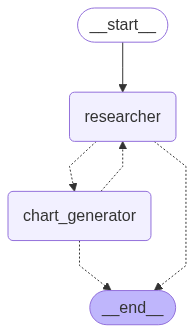

In [30]:
display(Image(app.get_graph().draw_mermaid_png()))

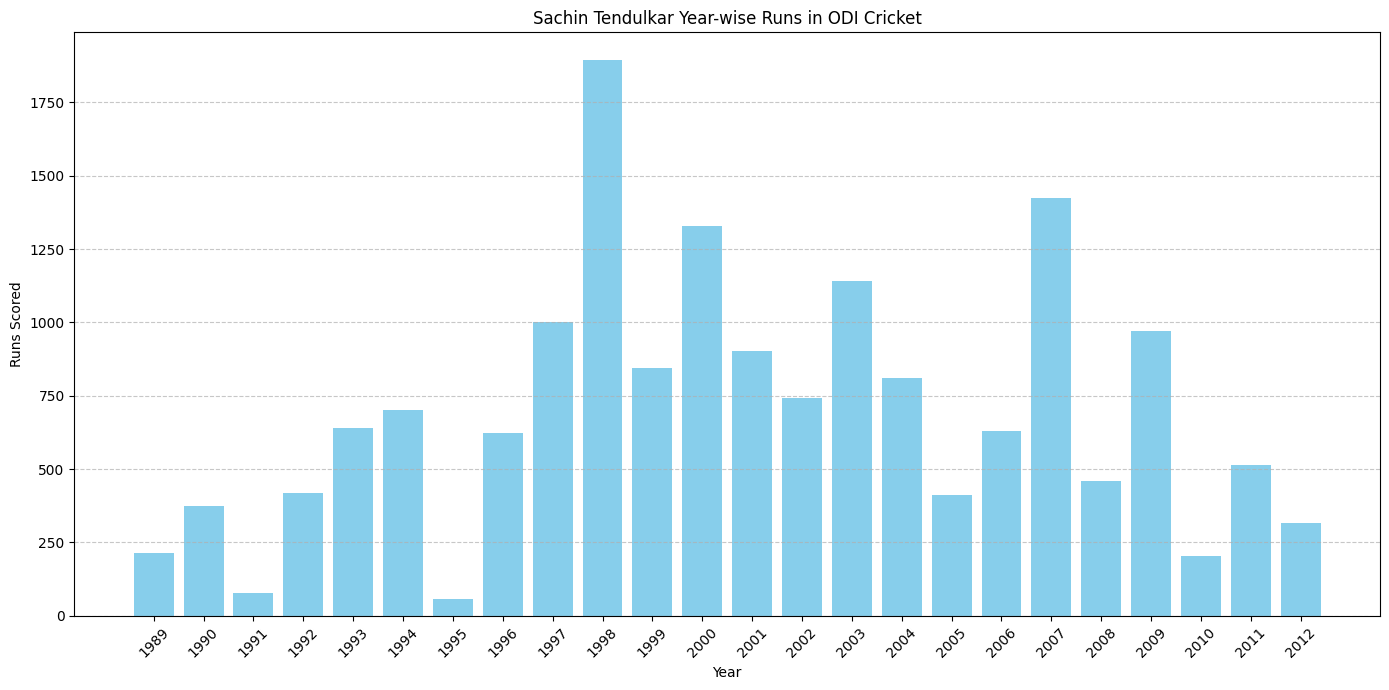

{'messages': [HumanMessage(content='Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket. \nAfter gathering the data, generate a clear and informative bar chart showing the runs performance over this period. \nOnce the chart is created, you may conclude the task.', additional_kwargs={}, response_metadata={}, id='c9aac0b4-6633-4640-b259-17826fba0d8d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RqPGzijIxeKVrmrObkOgF7X6', 'function': {'arguments': '{"query":"Sachin Tendulkar year wise runs in ODI cricket"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 231, 'total_tokens': 259, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14

In [31]:
app.invoke({
    "messages": [
        (
            "user",
            "Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket. \n"
            "After gathering the data, generate a clear and informative bar chart showing the runs performance over this period. \n"
            "Once the chart is created, you may conclude the task."
        )
    ]
})

In [ ]:
app.invoke({
    "messages": [
        (
            "user",
            "Please retrieve the historical data for India NIFTY50 INDEX for past 3 years. \n"
            "After gathering the data, generate a clear and informative line chart showing the index performance over this period. \n"
            "Once the chart is created, you may conclude the task."
        )
    ]
})